# HappyCustomerBank - Machine Learning

## Loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.simplefilter('ignore', FutureWarning)

In [2]:
X = np.load('X_hcb.npy')
y = np.load('y_hcb.npy')

In [3]:
# Splitting the data into test and train sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

## Cost function

In [4]:
def financial_score(y_true, y_pred):
    y_true = y_true.ravel().astype(int)
    y_pred = y_pred.ravel().astype(int)
    prediction_cost = y_pred.sum() * 100
    good_prediction_gain = (y_pred & y_true).sum() * 1000    
    return good_prediction_gain - prediction_cost

## Examining basic models
* Logistic Regression with default settings
* Logistic Regression with class weights

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report

In [6]:
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true=y_true,
                                     y_score=y_pred_proba)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr)
    plt.scatter(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--')
    auc = roc_auc_score(y_true=y_true,
                        y_score=y_pred_proba)
    plt.title('AUC: {:.5f}'.format(auc))
    plt.show()

In [7]:
def get_best_threshold_for_F1(y_true, y_pred_prob, thresholds_number = 500):
    thresholds = np.linspace(start=0, stop=1, num=thresholds_number).tolist()
    f1_scores = []

    for t in thresholds:
        f1_scores.append(f1_score(y_true, (y_pred_prob>t)))

    scores_df = pd.DataFrame({'threshold': thresholds, 'F1': f1_scores})
    return scores_df[scores_df.F1 == scores_df.F1.max()]['threshold'].iloc[0]

In [8]:
def get_best_threshold_for_profit(y_true, y_pred_prob, thresholds_number = 500):
    thresholds = np.linspace(start=0, stop=1, num=thresholds_number).tolist()
    profit_scores = []

    for t in thresholds:
        profit_scores.append(financial_score(y_true, (y_pred_prob>t)))

    scores_df = pd.DataFrame({'threshold': thresholds, 'profit': profit_scores})
    return scores_df[scores_df.profit == scores_df.profit.max()]['threshold'].iloc[0]

### Logistic Regression with default settings

In [10]:
model_bs = LogisticRegression()
model_bs.fit(X_train, y_train)

LogisticRegression()

In [13]:
# Train set results:
y_pred_proba_train_bs = model_bs.predict_proba(X_train)[:, 1]
print(classification_report(y_train, (y_pred_proba_train_bs > 0.5)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     77172
         1.0       0.86      0.42      0.56      1146

    accuracy                           0.99     78318
   macro avg       0.93      0.71      0.78     78318
weighted avg       0.99      0.99      0.99     78318



In [15]:
# Next, we can find optimal thresholds values from two perspectives - maximizing F1 score and maximizing profit.
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_bs)
f1 = f1_score(y_train, (y_pred_proba_train_bs > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

threshold_profit = get_best_threshold_for_profit(y_train, y_pred_proba_train_bs)
profit = financial_score(y_train, (y_pred_proba_train_bs > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max F1 score: 0.5874 for threshold: 0.3046
Max profit: 517000 PLN for threshold: 0.1162


In [16]:
def plot_distributions_and_thresholds(y_pred_proba, 
                                      y_true, 
                                      threshold_profit, 
                                      threshold_f1, 
                                      title):
    plt.hist(y_pred_proba[y_true==0], label='0', bins=50, alpha=0.5)
    plt.hist(y_pred_proba[y_true==1], label='1', bins=50, alpha=0.5)
    plt.vlines(threshold_profit, 0, 100, color='green', linestyle='--',  label='max profit threshold')
    plt.vlines(threshold_f1, 0, 100, color='red', linestyle='--', label='max F1 threshold')
    plt.yscale('log')
    plt.legend()
    plt.title(title)

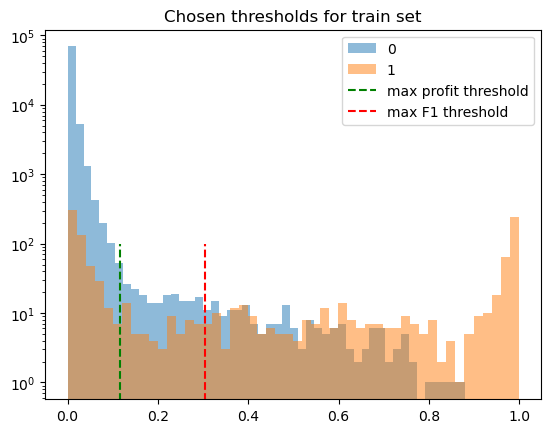

In [17]:
plot_distributions_and_thresholds(y_pred_proba_train_bs, 
                                  y_train, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for train set')

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      8575
         1.0       0.90      0.44      0.59       127

    accuracy                           0.99      8702
   macro avg       0.95      0.72      0.79      8702
weighted avg       0.99      0.99      0.99      8702



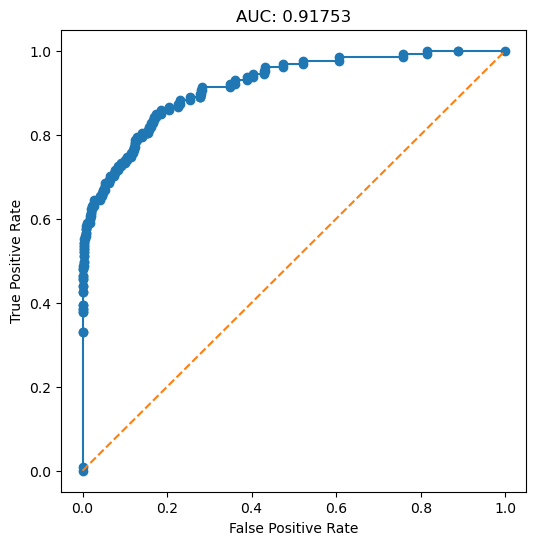

In [18]:
# Test set results
y_pred_proba_test_bs = model_bs.predict_proba(X_test)[:, 1]
print(classification_report(y_test, (y_pred_proba_test_bs > 0.5)))
plot_roc_curve(y_test, y_pred_proba_test_bs)

In [19]:
f1 = f1_score(y_test, (y_pred_proba_test_bs > threshold_f1))
print('Test set F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

profit = financial_score(y_test, (y_pred_proba_test_bs > threshold_profit))
print('Test set profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Test set F1 score: 0.6047 for threshold: 0.3046
Test set profit: 58500 PLN for threshold: 0.1162


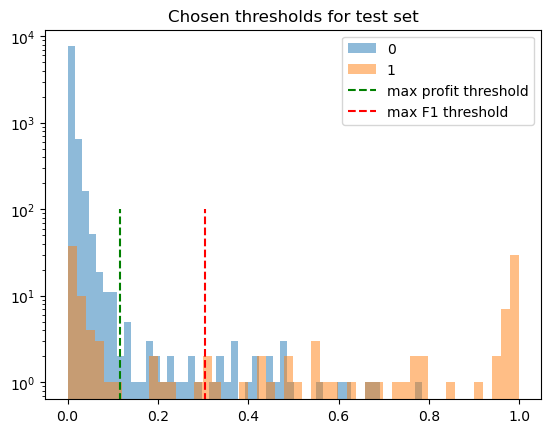

In [20]:
plot_distributions_and_thresholds(y_pred_proba_test_bs, 
                                  y_test, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for test set')

### Logistic Regression with class weights

In [24]:
imbalance_ratio = len(np.where(y_train == 0)[0]) / len(np.where(y_train == 1)[0])
imbalance_ratio

67.34031413612566

In [23]:
model_bs = LogisticRegression(class_weight={0: 1, 1: imbalance_ratio})
model_bs.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 67.34031413612566})

In [25]:
# Train set results
y_pred_proba_train_bs = model_bs.predict_proba(X_train)[:, 1]
print(classification_report(y_train, (y_pred_proba_train_bs > 0.5)))

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93     77172
         1.0       0.08      0.81      0.15      1146

    accuracy                           0.86     78318
   macro avg       0.54      0.84      0.54     78318
weighted avg       0.98      0.86      0.91     78318



In [26]:
threshold_f1 = get_best_threshold_for_F1(y_train, y_pred_proba_train_bs)
f1 = f1_score(y_train, (y_pred_proba_train_bs > threshold_f1))
print('Max F1 score: {:.4f} for threshold: {:.4f}'.format(f1, threshold_f1))

threshold_profit = get_best_threshold_for_profit(y_train, y_pred_proba_train_bs)
profit = financial_score(y_train, (y_pred_proba_train_bs > threshold_profit))
print('Max profit: {} PLN for threshold: {:.4f}'.format(profit, threshold_profit))

Max F1 score: 0.5813 for threshold: 0.9699
Max profit: 510700 PLN for threshold: 0.9098


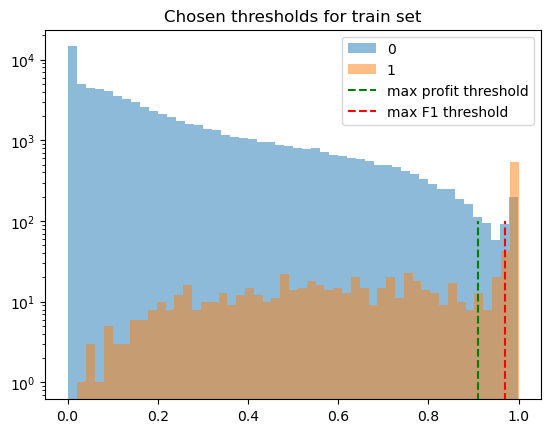

In [27]:
plot_distributions_and_thresholds(y_pred_proba_train_bs, 
                                  y_train, 
                                  threshold_profit, 
                                  threshold_f1,
                                  'Chosen thresholds for train set')

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93      8575
         1.0       0.08      0.77      0.15       127

    accuracy                           0.87      8702
   macro avg       0.54      0.82      0.54      8702
weighted avg       0.98      0.87      0.92      8702



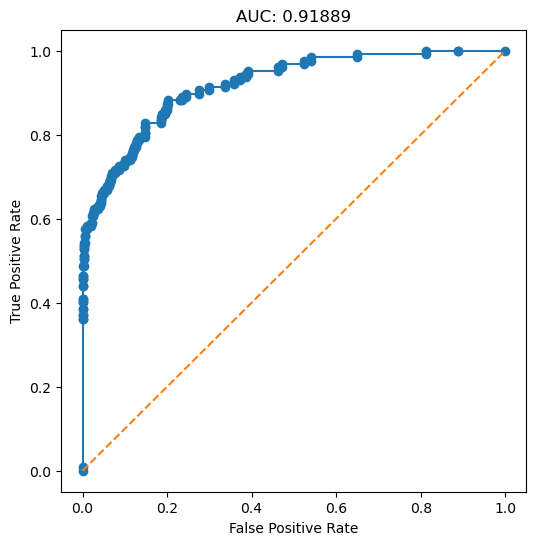

In [28]:
# Test set results
y_pred_proba_test_bs = model_bs.predict_proba(X_test)[:, 1]
print(classification_report(y_test, (y_pred_proba_test_bs > 0.5)))
plot_roc_curve(y_test, y_pred_proba_test_bs)

### Exploring models with weighting classes techniques.

In [29]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold

In [30]:
models = [
    [('LogReg', LogisticRegression())],
    [('Bagging', BaggingClassifier(DecisionTreeClassifier(),
                                   max_samples=0.7,
                                   bootstrap=True))]
]

params_grid = [
     {'LogReg__C': [0.001, 0.01, 0.1, 1, 10, 100], 
     'LogReg__penalty': ['l1', 'l2'],
     'LogReg__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 40}, {0: 1, 1: 60}, {0: 1, 1: 80}]
    },
     {'Bagging__n_estimators': [200], 
      'Bagging__max_features': [10, 20],
      'Bagging__base_estimator__max_depth': [5, 10, 20, 40],
      'Bagging__base_estimator__min_samples_leaf': [5, 15, 20, 40],
      'Bagging__base_estimator__min_samples_split': [5, 15, 20, 40],
      'Bagging__base_estimator__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 40}, {0: 1, 1: 60}, {0: 1, 1: 80}]
     }
]

In [31]:
from sklearn.metrics import make_scorer

In [32]:
def financial_score_with_best_threshold(y_true, y_pred_proba):
    optimal_threshold = get_best_threshold_for_profit(y_true, y_pred_proba)
    profit = financial_score(y_true, (y_pred_proba > optimal_threshold))
    return profit

In [ ]:
best_models = []
best_results = []
for pipe, params in zip(models, params_grid):
    pipeline = Pipeline(pipe)
    
    gs = GridSearchCV(estimator=pipeline,
                      param_grid=params,
                      cv=StratifiedKFold(10),
                      scoring=make_scorer(financial_score_with_best_threshold, needs_proba=True),
                      verbose=1,
                      n_jobs=-1)
    
    gs.fit(X_train, y_train)
    best_models.append(gs.best_estimator_)
    results = gs.cv_results_
    y_pred_proba = gs.best_estimator_.predict_proba(X_test)[:, 1]
    best_threshold = get_best_threshold_for_profit(y_test, y_pred_proba, thresholds_number=1000)

    results['test_set_financial_score'] = financial_score(y_test, (y_pred_proba>best_threshold))
    best_results.append(pd.DataFrame(results))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


C:\ProgramData\Anaconda3x2\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3x2\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3x2\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3x2\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, sel

Fitting 10 folds for each of 512 candidates, totalling 5120 fits


In [ ]:
best_results[1]

In [ ]:
best_models[1][0].get_params()